Get rid of Warnings from code

https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

Install and import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as skm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dell\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


### Load Dataset

In [3]:
df = pd.read_csv('D:/Seattle Folder/Spring 2025/Data 5322 Statistical Machine Learning II/PracticalWorksheet02/nhis_2022.csv')
df.head(5)


,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,...,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,...,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,...,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,...,996,996,996,996,996,996,996,996,0,2
3,2022,3,134,13,0002022H000006,2,1,0002022H00000610,H000006,2681.0,...,1,1,1,0,2,0,1,1,6,2
4,2022,4,106,53,0002022H000007,3,1,0002022H00000710,H000007,10233.0,...,3,30,5,1,0,30,6,2,8,2


Create a Subset of Original Data on the basis of responses recieve from different regions, Sex, Age

In the region feature there are 6 categories, enlisted below. 

01 - Northeast
02 - North Central/Midwest
03 - South
04 - West
08- NO DATA IN ROUND
09 - Unknown

We are selecting 03 (South region response to subset the original dataset)

In [4]:
subset_df = df[df['REGION'] == 3]
subset_df.shape

(12954, 48)

Only Select those responses whose age range is between 18 and 97

In [5]:
subset_df = subset_df[subset_df['AGE'].isin(range(18, 97))]  # Assuming 96 is the top coded real age

subset_df.shape

(10146, 48)

Only Select Male Responses 

In [6]:
subset_df = subset_df[(subset_df['SEX'].isin([1]))]# only keep those entries which give useful meaning in the data (7: unknown-refused, 8: unknown-not ascerted, 9: unknown-don't know)

subset_df.shape

(4507, 48)

Only keep those entries in the Target features which gives meaningful information

1 means No 

2 means Yes

In [7]:
cols = ['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV']

# Keep rows where ALL disease indicators are 1 or 2 (no 0s)
subset_df = subset_df[(subset_df[cols].isin([1, 2])).all(axis=1)]
subset_df.shape

(4487, 48)

In survey datasets like some values are special codes that mean "missing" or "not valid." For example:

997 = Refused

998 = Not Ascertained

999 = Don't Know

Remove those special codes


In [8]:
subset_df = subset_df[~subset_df.isin([996, 997, 998, 999]).any(axis=1)]
subset_df.shape


(3546, 48)


As instruted by the professor to drop features from Survey information (variables 1-12): These variables are ID numbers or sample weights from the survey methodology. we can largely ignore these for this homework, but know that this is not a representative sample for the United States-- weighting is important to make extrapolating claims. 

In [9]:

subset_df = subset_df.drop(subset_df.iloc[:, 0:12], axis=1)
subset_df.shape

(3546, 36)

In [10]:
subset_df.columns

Index(['AGE', 'SEX', 'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT',
       'WEIGHT', 'BMICALC', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV',
       'DIABETICEV', 'HEARTATTEV', 'STROKEV', 'ALCANYNO', 'ALCDAYSYR',
       'CIGDAYMO', 'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO',
       'SALADSNO', 'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO',
       'SPORDRMNO', 'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO',
       'HRSLEEP', 'CVDSHT'],
      dtype='object')

In [11]:
targer_df = subset_df[['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV']]
new_df = subset_df.drop(columns=['CANCEREV', 'CHEARTDIEV', 'DIABETICEV', 'HEARTATTEV', 'STROKEV'])

In [12]:
targer_df.head(5)

,CANCEREV,CHEARTDIEV,DIABETICEV,HEARTATTEV,STROKEV
1,1,1,1,1,1
4,1,1,1,1,1
12,2,1,1,1,1
33,2,2,2,1,1
50,1,1,1,1,1


In [13]:
new_df.columns


Index(['AGE', 'SEX', 'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT',
       'WEIGHT', 'BMICALC', 'HINOTCOVE', 'ALCANYNO', 'ALCDAYSYR', 'CIGDAYMO',
       'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO', 'HRSLEEP',
       'CVDSHT'],
      dtype='object')

#### Research Question : In this practical worksheet there are total 5 predictors defined in the dataset among 5 of them we are selecting one predictor which is DIABETICEV (Diabetes ever) variable. Along with predictors there are some other indicators used such as life style, food consumption, demographics. Based on these features we want to know Can lifestyle, sleep, age, healthy food, sugary drinks, and weight predict diabetes?


### Split the data into training and testing 

In [14]:
# Select predictors

features = [new_df.columns]
target = 'DIABETICEV'

# Drop missing values
#diabestes_df = subset_df.dropna(subset=features + [target])

# Get all columns except target
X = new_df
y = targer_df[target]

# Check shapes
#print(X.shape, y.shape)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Check Class Imbalance Issue in target feature 

Class distribution:
DIABETICEV
1    3114
2     432
Name: count, dtype: int64


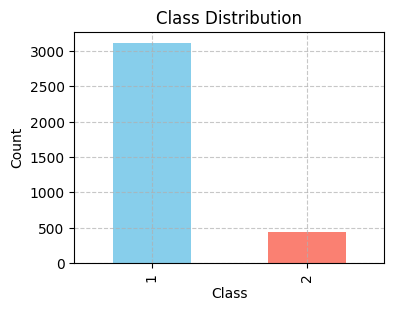


Class proportions:
DIABETICEV
1    0.878173
2    0.121827
Name: proportion, dtype: float64


In [15]:

# 1. Check the class distribution
print("Class distribution:")
print(y.value_counts())

# 2. Plot the distribution for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Calculate imbalance ratio (optional)
imbalance_ratio = y.value_counts(normalize=True)
print("\nClass proportions:")
print(imbalance_ratio)


Severely Imbalanced Dataset ➔ ~87% vs ~12%

Majority Class (Non-Diabetic) ➔ dominates the dataset.

Minority Class (Diabetic) ➔ very underrepresented

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/


SVM Parameter Tuning: We conducted a grid search over the following parameter ranges to select the optimal model. Only the best parameters and results from cross-validation are reported below.

 Linear Kernel SVM

In [16]:
# 1. Define param grid (only C, because kernel is fixed to 'linear')
param_grid = {
    'C': [ 0.1, 1, 5, 10]
}

# 2. Setup GridSearchCV with a linear kernel SVM
linear_svm = SVC(kernel='linear', class_weight='balanced')  # Fix the kernel to 'linear'
grid = GridSearchCV(
    estimator=linear_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1

)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameter
print(f"Best C: {grid.best_params_}")

# 5. Predict with the best model
best_linear_model = grid.best_estimator_
predictions = best_linear_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

grid.cv_results_[('mean_test_score')]


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best C: {'C': 5}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.95      0.68      0.79       788
           2       0.22      0.70      0.33        99

    accuracy                           0.68       887
   macro avg       0.58      0.69      0.56       887
weighted avg       0.87      0.68      0.74       887



array([0.67394404, 0.67394404, 0.68146779, 0.67658482])

RBF Kernel SVM

In [17]:


# 1. Define param grid (now tuning both C and gamma for RBF)
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization strength
    'gamma':[0.001, 0.01, 0.1, 1]   # Gamma controls shape of decision boundary
}

# 2. Setup GridSearchCV with RBF kernel SVM
rbf_svm = SVC(kernel='rbf', class_weight='balanced')  # Fix kernel to 'rbf'

grid = GridSearchCV(
    estimator=rbf_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1
)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameters
print(f"Best Parameters: {grid.best_params_}")

# 5. Predict with the best model
best_rbf_model = grid.best_estimator_
predictions = best_rbf_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

# 7. Optionally show mean cross-validation scores
grid.cv_results_[('mean_test_score')]


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'gamma': 0.1}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.89      1.00      0.94       788
           2       0.00      0.00      0.00        99

    accuracy                           0.89       887
   macro avg       0.44      0.50      0.47       887
weighted avg       0.79      0.89      0.84       887



array([0.85144429, 0.42589312, 0.42589312, 0.42589312, 0.82173584,
       0.87326084, 0.8747653 , 0.8747653 , 0.83452062, 0.87363678,
       0.8747653 , 0.8747653 , 0.84053991, 0.87363678, 0.8747653 ,
       0.8747653 ])

Polynomial Kernel SVM

In [18]:

# 1. Define param grid (tuning C and degree for polynomial)
param_grid = {
    'C': 	[0.1, 1, 5, 10],           # Regularization parameter
    'degree': [2, 3, 4, 5]              # Degree of polynomial kernel
}

# 2. Setup GridSearchCV with polynomial kernel SVM
poly_svm = SVC(kernel='poly', class_weight='balanced')  # Fix kernel to 'poly'

grid = GridSearchCV(
    estimator=poly_svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    refit=True,
    verbose=3,
    n_jobs=-1
)

# 3. Fit the grid search
grid.fit(X_train, y_train)

# 4. Print best hyperparameters
print(f"Best Parameters: {grid.best_params_}")

# 5. Predict with the best model
best_poly_model = grid.best_estimator_
predictions = best_poly_model.predict(X_test)

# 6. Show classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, predictions))

# 7. Optionally, view cross-validation scores
grid.cv_results_[('mean_test_score')]

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 5, 'degree': 3}
Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           1       0.95      0.66      0.78       788
           2       0.21      0.73      0.33        99

    accuracy                           0.66       887
   macro avg       0.58      0.69      0.55       887
weighted avg       0.87      0.66      0.73       887



array([0.5810423 , 0.54192756, 0.50356187, 0.47083811, 0.67431219,
       0.66378446, 0.64121816, 0.59307379, 0.67958385, 0.68296731,
       0.67845532, 0.64498393, 0.68259137, 0.68296589, 0.68259137,
       0.65852555])

### Classification Report Interpretation


1. Linear SVM

Class 1: Similar to the polynomial model — strong precision (0.95) and fair recall (0.68). Class 2: Low precision (0.22) but fairly high recall (0.70), suggesting the model correctly identifies diabetic cases but also produces false positives. Performs similarly to the polynomial SVM; better than RBF for detecting diabetes. Suitable if recall for diabetic cases is a priority.

2. Polynomial SVM

Class 1 (Non-Diabetic): High precision (0.95) indicates most predicted "No" cases were correct, but recall (0.66) shows some actual "No" cases were missed. Class 2 (Diabetic): Low precision (0.21) but relatively high recall (0.73), meaning it identified many diabetic individuals but with many false positives. This model is better at capturing the minority class (diabetic), though at the cost of some precision.

3. RBF SVM

Class 1: Extremely high recall (1.00) and strong precision (0.89), showing the model perfectly predicts "No" cases. Class 2: Precision, recall, and f1-score are all 0.00 — the model completely failed to identify diabetic cases. Despite high overall accuracy (89%), this model is not useful for predicting diabetes due to total failure on minority class. Accuracy is misleading here due to class imbalance.

### Features Importance

Feature importance has been identified with the help of correlation matrix. Earlier We computed top 5 features based on each model performance. In result, we were getting 0 importance for RBF and Polynomical kernel which might not be useful for drawing decision boundaries in SVM. Using correlation matrix would give us overall correlated feature with taregt variable which is DIABETICEV. We have only kept positive correlation. 

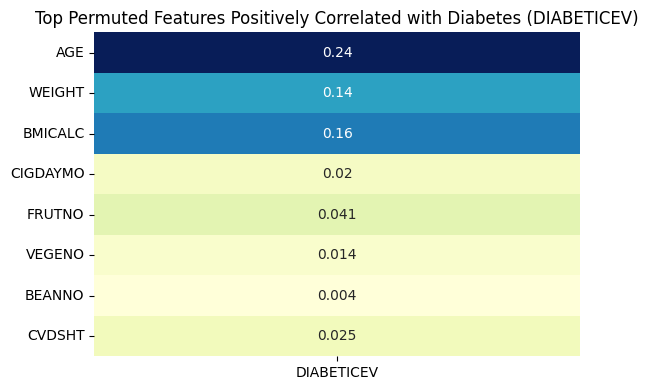

In [ ]:
important_feature = X.columns.to_list()

# Create a new DataFrame with only top 5 features and target variable
top_features = X[important_feature].copy()
top_features['DIABETICEV'] = y  # y must be your target variable

# Compute correlation matrix
corr_matrix = top_features.corr(numeric_only=True)
target_corr = corr_matrix['DIABETICEV'].drop('DIABETICEV')

# Filter only features with positive correlation
positive_corr = target_corr[target_corr > 0]


#Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(positive_corr.to_frame(), annot=True, cmap='YlGnBu', cbar=False)
plt.title('Top Permuted Features Positively Correlated with Diabetes (DIABETICEV)', fontsize=12)
plt.tight_layout()
plt.show()

### Role of support vectors in determining the decision boundary

In a support vector machine (SVM), the support vectors are the data points that are closest to the decision boundary and have the greatest impact on the position of the boundary. The decision boundary is a hyperplane in an N-dimensional space (where N is the number of features) that separates the data points into different classes. FOr the decision boundary, we are selecting BMICALC as a feature of X and AGE as a feature of y

### SVM Decision Boundary for Linear Kernel

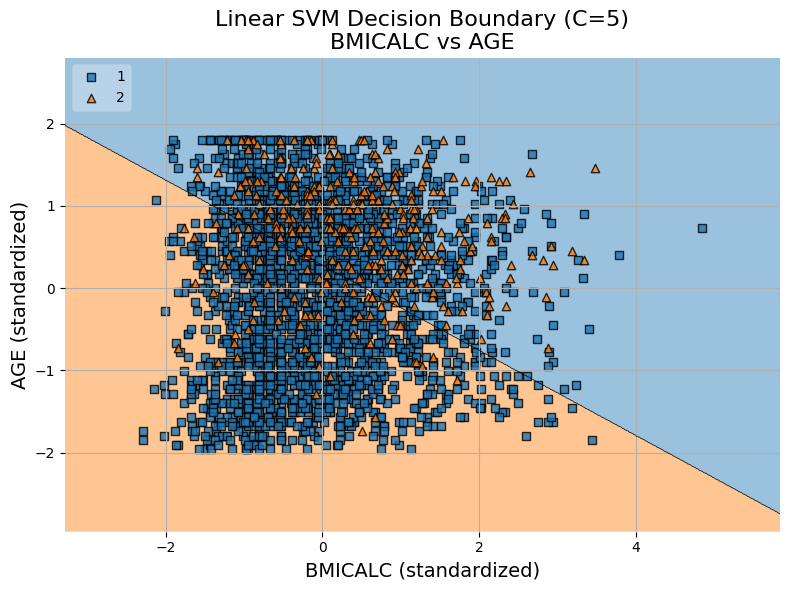

In [22]:
# Example: Manually choose known continuous features
feature_x = 'BMICALC'  # Body Mass Index
feature_y = 'AGE'      # Age

X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# Train with best C from previous GridSearch
svm_vis = SVC(kernel='linear', C=grid.best_params_['C'], class_weight='balanced')
svm_vis.fit(X_scaled, y_plot)

# Plot
plt.figure(figsize=(8, 6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=svm_vis, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title(f'Linear SVM Decision Boundary (C={grid.best_params_["C"]})\n{feature_x} vs {feature_y}', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()


SVM Boundary for RBF Kernel

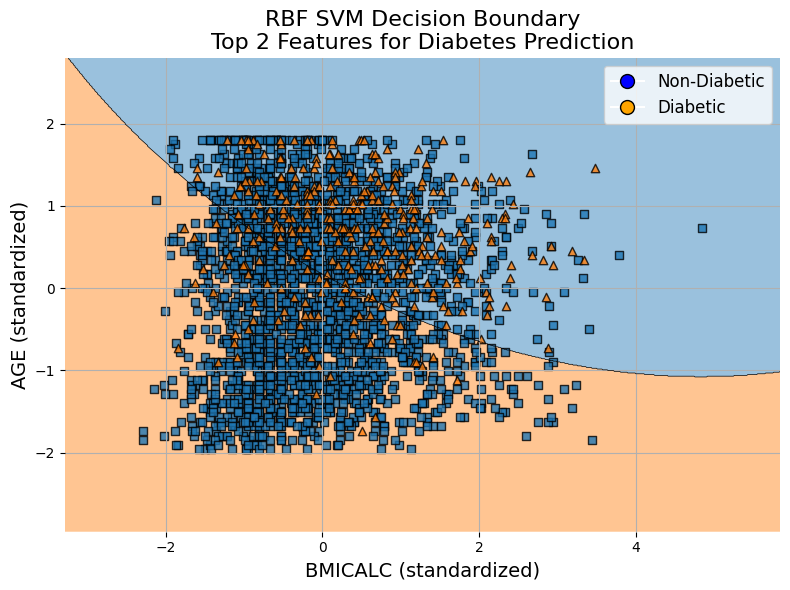

In [23]:

# 1. Choose 2 good continuous features
feature_x = 'BMICALC'
feature_y = 'AGE'
X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# 2. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# 3. Define and train RBF SVM model
rbf_svm = SVC(kernel='rbf', C=1, gamma=0.01, class_weight='balanced')
rbf_svm.fit(X_scaled, y_plot)

# 4. Plot the decision boundary
plt.figure(figsize=(8,6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=rbf_svm, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title('RBF SVM Decision Boundary\nTop 2 Features for Diabetes Prediction', fontsize=16)
plt.grid(True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Diabetic',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Diabetic',
           markerfacecolor='orange', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

SVM  Decision Boundary for Polynomial Kernel

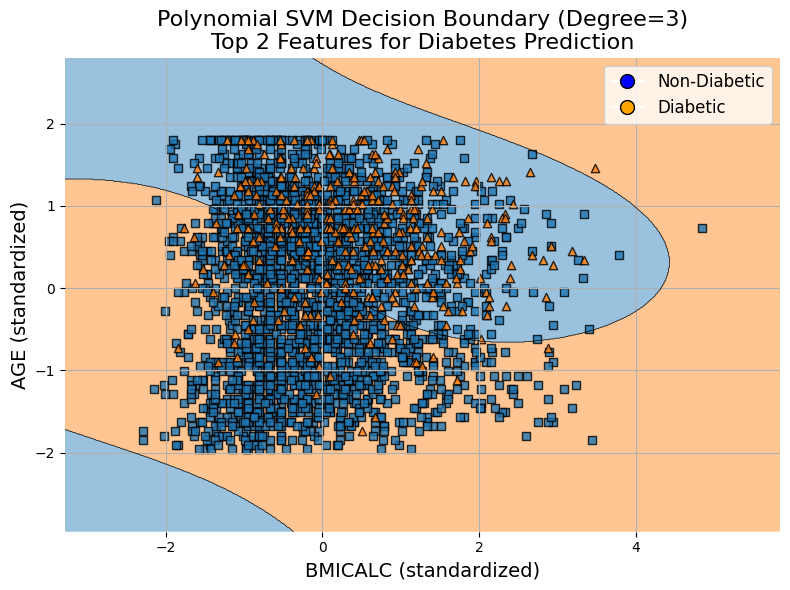

In [24]:
# 1. Choose same 2 features
feature_x = 'BMICALC'
feature_y = 'AGE'
X_plot = X_train[[feature_x, feature_y]]
y_plot = y_train

# 2. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

# 3. Define and train Polynomial SVM model
poly_svm = SVC(kernel='poly', degree=3, C=5, coef0=1, class_weight='balanced')  
poly_svm.fit(X_scaled, y_plot)

# 4. Plot
plt.figure(figsize=(8,6))
plot_decision_regions(X_scaled, y_plot.to_numpy().astype(int), clf=poly_svm, legend=2)

plt.xlabel(f'{feature_x} (standardized)', fontsize=14)
plt.ylabel(f'{feature_y} (standardized)', fontsize=14)
plt.title('Polynomial SVM Decision Boundary (Degree=3)\nTop 2 Features for Diabetes Prediction', fontsize=16)
plt.grid(True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Diabetic',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Diabetic',
           markerfacecolor='orange', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


### SVM Decision Boundaries for (Linear, RBF, Polynomial) Analysis

Linear SVM Decision Boundary 

This SVM decision boundary plot shows how the linear kernel separates diabetic and non-diabetic individuals based on standardized BMI and age.
The boundary suggests that individuals with higher BMI and younger age are more likely to be classified as diabetic.
However, there is significant class overlap, indicating that BMI and age alone may not provide strong separation for diabetes prediction.


RBF SVM Decision Boundary

This RBF SVM decision boundary plot captures more complex, nonlinear patterns between BMI, age, and diabetes status.
The curved boundary adapts to clusters better than the linear model, but class overlap remains significant.
It shows that while BMI and age carry some predictive power, they may not be sufficient alone to clearly separate diabetic from non-diabetic individuals.

Polynomial SVM Decision Boundary

This Polynomial SVM decision boundary (degree=2) demonstrates a more flexible, curved separation between diabetic and non-diabetic groups using BMI and age.
The wavy boundary indicates interactions between the two variables, but it still struggles with overlapping regions.
This suggests that while a polynomial kernel captures more complexity than a linear one, additional features may be needed to improve classification.







